In [7]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/enhanced-k-rcps

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/enhanced-k-rcps


In [8]:
import os
import torch
import numpy as np
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import seaborn as sns
from PIL import Image

sns.set_theme(style="white")
sns.set_context("talk")
figsize = (256 / 30, 128 / 30)

In [9]:
from krcps.utils import _split_idx

n = 256
gt = Image.open(os.path.join("assets", "ground_truth.jpg"))
gt = TF.to_tensor(gt)
x = torch.rand(n, *gt.size())

m = 12
M = (torch.mean(gt, dim=0) >= 0.5).long()
mu = x + 0.2 * torch.randn_like(x) * (1 - M) + 0.8 * torch.randn_like(x) * M
mu = mu.unsqueeze(1)
mu = mu.repeat(1, m, 1, 1, 1)
y = torch.randn_like(mu) * 0.1 + mu

n_val = 64
val_idx, cal_idx = _split_idx(n, n_val)

cal_x, cal_y = x[cal_idx], y[cal_idx]
val_x, val_y = x[val_idx], y[val_idx]

In [10]:
from krcps.utils import get_uq
from krcps.utils import get_calibration

m_cal_x, m_cal_y = torch.mean(cal_x, dim=1), torch.mean(cal_y, dim=2)
m_val_x, m_val_y = torch.mean(val_x, dim=1), torch.mean(val_y, dim=2)

alpha = 0.10
calibrated_quantile_fn = get_uq("calibrated_quantile", alpha=alpha, dim=1)
m_cal_i = calibrated_quantile_fn(m_cal_y)

rcps_fn = get_calibration("rcps")
krcps_fn = get_calibration("k_rcps")

epsilon = delta = 0.10
lambda_max = 0.5
stepsize = 2e-03
_lambda = rcps_fn(
    m_cal_x, m_cal_i, "vector_01", "hoeffding_bentkus", epsilon, delta, lambda_max, stepsize
)

k = 2
n_opt = 128
prob_size = 50
gamma = np.linspace(0.25, 0.75, 16)
_lambda_k = krcps_fn(
    m_cal_x,
    m_cal_i,
    "hoeffding_bentkus",
    epsilon,
    delta,
    lambda_max,
    stepsize,
    k,
    ["01_loss_kmeans", "01_loss_otsu"],
    n_opt,
    prob_size,
    gamma,
)

100%|██████████| 0.1/0.1 [00:18<00:00, 189.83s/it]
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
100%|██████████| 16/16 [00:09<00:00,  1.74it/s]
100%|██████████| 0.1/0.1 [07:08<00:00, 4282.04s/it]


In [11]:
val_i = calibrated_quantile_fn(m_val_y)

_lambda_l, _lambda_u = val_i(_lambda)
rcps_mu_i = torch.mean(_lambda_u - _lambda_l)
print(f"RCPS, mean interval length: {rcps_mu_i:.4f}")

_lambda_k_l, _lambda_k_u = val_i(_lambda_k)
k_rcps_mu_i = torch.mean(_lambda_k_u - _lambda_k_l)
print(f"K-RCPS, mean interval length: {k_rcps_mu_i:.4f}")
print(
    f"K-RCPS reduces the mean interval length by {100 * (rcps_mu_i - k_rcps_mu_i) / rcps_mu_i:.2f}%"
)

RCPS, mean interval length: 0.6139
K-RCPS, mean interval length: 0.5701
K-RCPS reduces the mean interval length by 7.14%


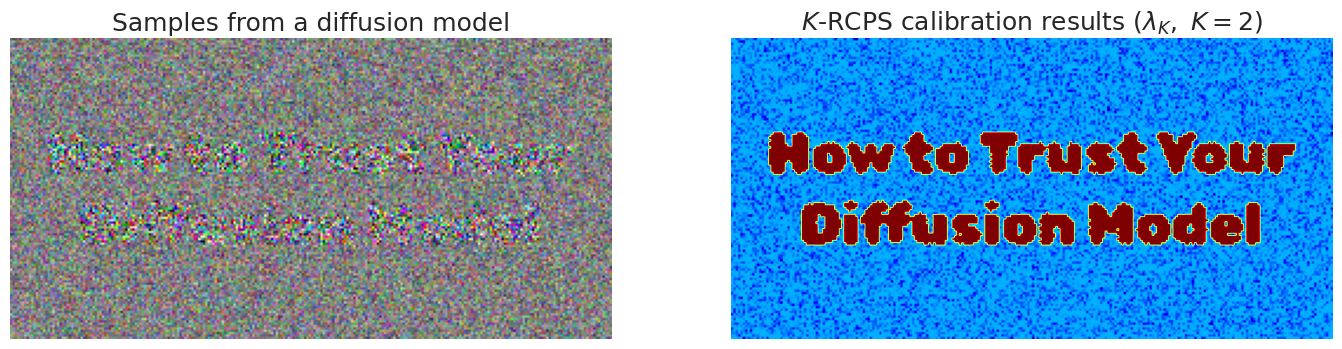

In [12]:
rc("animation", html="html5")

fig, axes = plt.subplots(1, 2, figsize=(2 * figsize[0], figsize[1]))
ax = axes[1]
ax.axis("off")
ax.set_title(r"$K$-RCPS calibration results ($\lambda_K,~K=2$)")
im = ax.imshow(_lambda_k, cmap="jet")

ax = axes[0]
samples = val_y[0]
vmin, vmax = torch.quantile(samples, torch.tensor([0.01, 0.99]))
samples = (samples - vmin) / (vmax - vmin)
samples = torch.clamp(samples, 0, 1)

ax.axis("off")
ax.set_title("Samples from a diffusion model")
im = ax.imshow(torch.zeros_like(gt).permute(1, 2, 0), cmap="gray", vmin=vmin, vmax=vmax)


def _init():
    im.set_data(torch.zeros_like(gt).permute(1, 2, 0))
    return (im,)


def _animate(i):
    im.set_data(samples[i].permute(1, 2, 0))
    return (im,)


anim = animation.FuncAnimation(fig, _animate, frames=m, init_func=_init)
anim.save(os.path.join("assets", "results.gif"), writer=animation.PillowWriter(fps=60))
plt.show()